In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import models
import tensorflow.keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score
import requests
import xmltodict
import json

C:\Users\Admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
plateCascade = cv2.CascadeClassifier(r'C:\Users\Admin\Desktop\Fall21-22\DIP\J component\indian_license_plate.xml')

In [4]:
#detect the plate and return car + plate image
def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plate_part = np.array([])
    plateRect = plateCascade.detectMultiScale(plateImg,scaleFactor = 1.2, minNeighbors = 7)
    for (x,y,w,h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg,(x+2,y),(x+w-3, y+h-5),(0,255,0),3)
    #print(type(roi))
    #print(roi.shape)
    return plateImg, plate_part

In [5]:
#normal function to display 
def display_img(img):
    img_ = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_)
    plt.show()

In [6]:
def find_contours(dimensions, img) :

    #finding all contours in the image using 
    #retrieval mode: RETR_TREE
    #contour approximation method: CHAIN_APPROX_SIMPLE
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Approx dimensions of the contours
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    #Check largest 15 contours for license plate character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ci = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detecting contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ci, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            #plt.imshow(ci, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    #return characters on ascending order with respect to the x-coordinate
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [7]:
def segment_characters(image) :

    #pre-processing cropped image of plate
    #threshold: convert to pure b&w with sharpe edges
    #erod: increasing the backgroung black
    #dilate: increasing the char white
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    #estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    #getting contours
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [8]:
#It is the harmonic mean of precision and recall
#Output range is [0, 1]
#Works for both multi-class and multi-label classification

def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [9]:
model = models.load_model(r'C:\Users\Admin\Desktop\Fall21-22\DIP\J component\license_plate_character.pkl', custom_objects= {'custom_f1score': custom_f1score})

In [10]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results(pl_char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(pl_char): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict_classes(img)[0]
        character = dic[y_] #
        output.append(character) 
        
    plate_number = ''.join(output)
    
    return plate_number

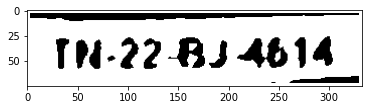

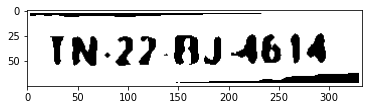

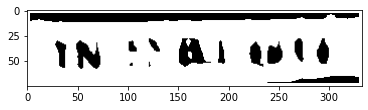

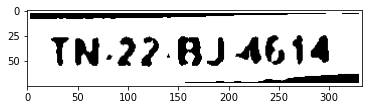

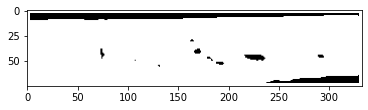

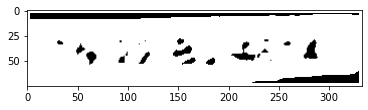

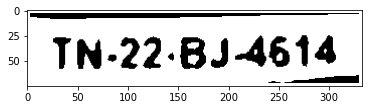

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2


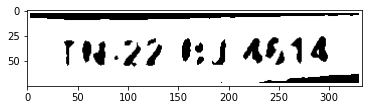

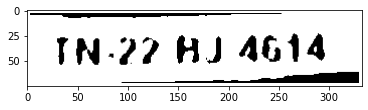

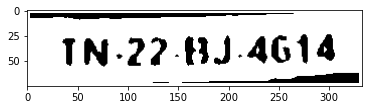

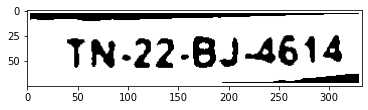

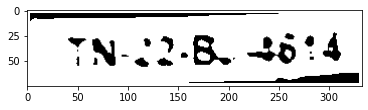

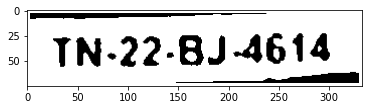

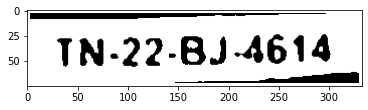

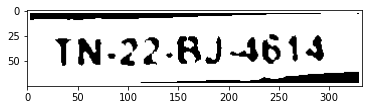

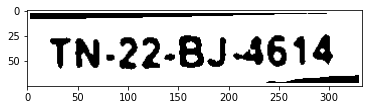

2B


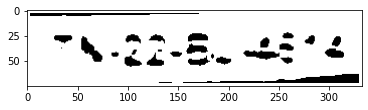

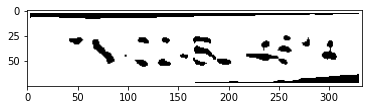

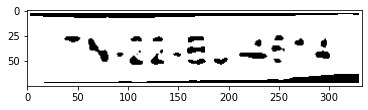

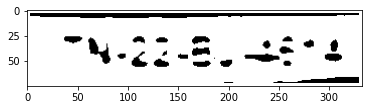

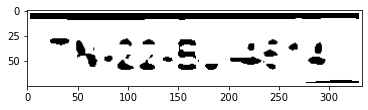

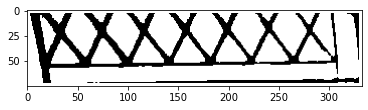

D1


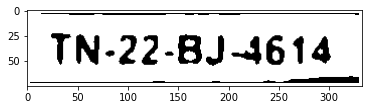

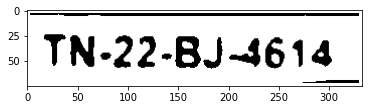

2


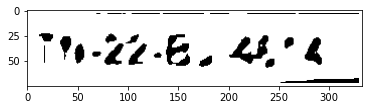

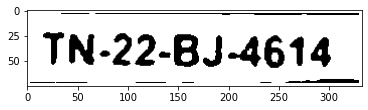

T2B6


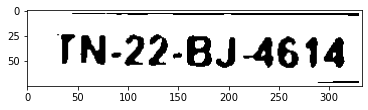

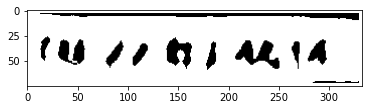

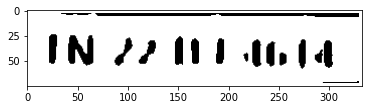

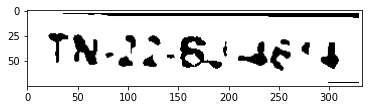

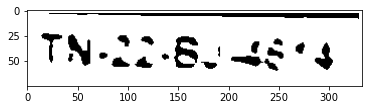

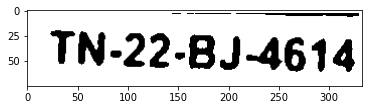

TN22BJ614


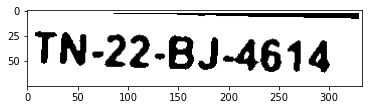

TN22BJ64


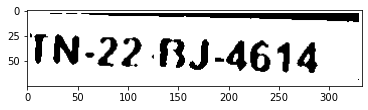

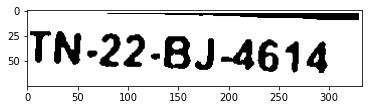

N2286


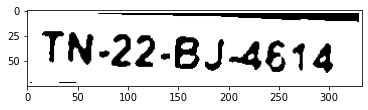

N28


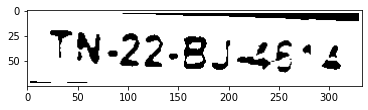

22E


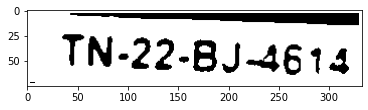

B


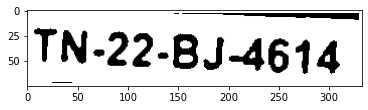

TN22BJ4614


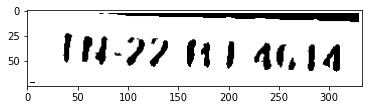

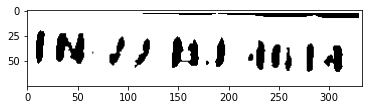

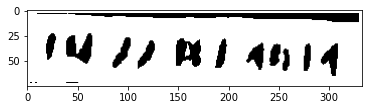

4


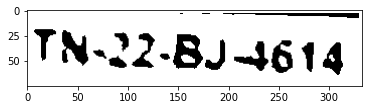

N2664


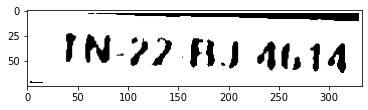

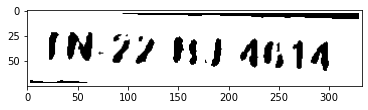

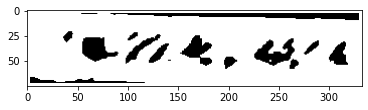

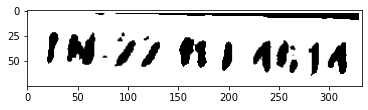

W4


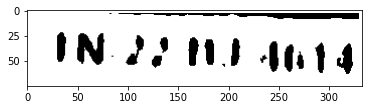

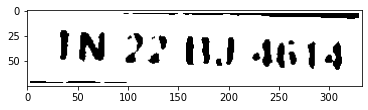

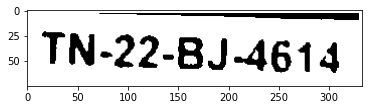

TN226


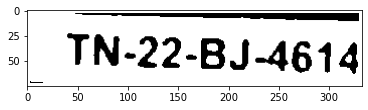

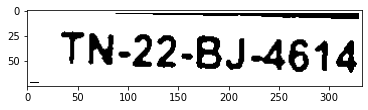

T22B64


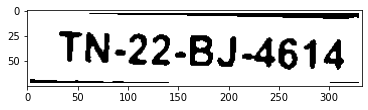

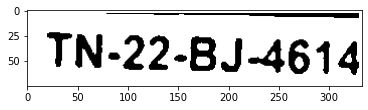

TN22BJ614


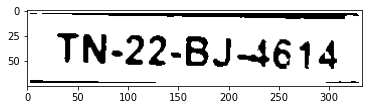

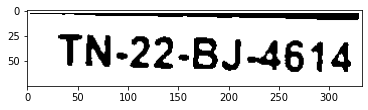

N2


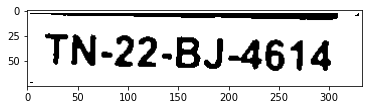

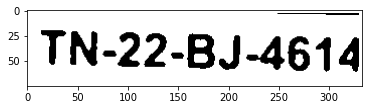

TN22BJ614


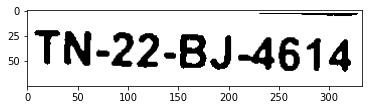

TN22BJ614


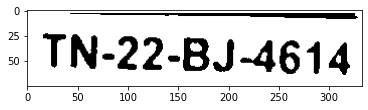

TN22BJ614


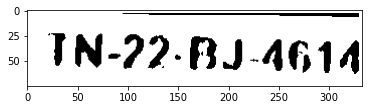

JN2704


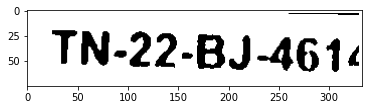

TN22BJ61


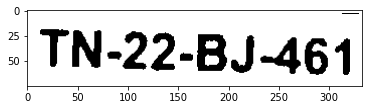

TN22BJ61


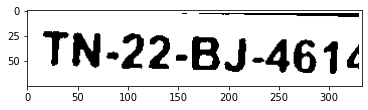

TN22BJ461


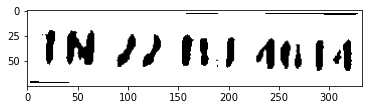

NJJ


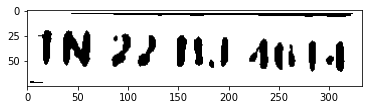

JNJ


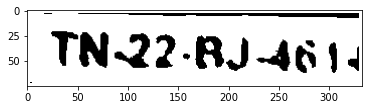

TN42RJ


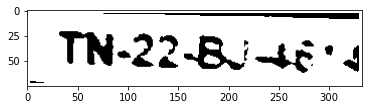

2


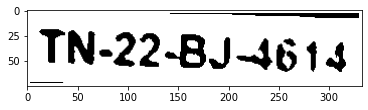

TN22


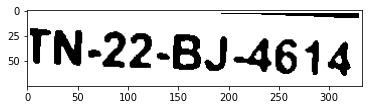

TN22BJ614


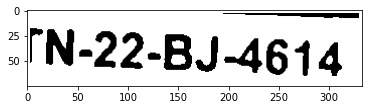

CN22BJ614


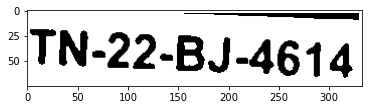

TN22BJ4614


In [12]:
cam = cv2.VideoCapture(r'C:\Users\Admin\Desktop\Fall21-22\DIP\J component\IMG_5294.mp4')
if cam.isOpened() == False:
    print("Video not imported")

plate_list = []  
info_list = []
while(cam.isOpened()):
    ret, frame = cam.read()
    if ret == True:
        car_plate, plate_img = plate_detect(frame)
        cv2.imshow("License Video",car_plate)
        if len(plate_img) > 0:
            plate_char = segment_characters(plate_img)
            number_plate = show_results(plate_char)
            print(number_plate)
          
                
        if cv2.waitKey(1) == 27:
            break
    else:
        break

cam.release()
cv2.destroyAllWindows()



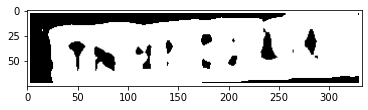

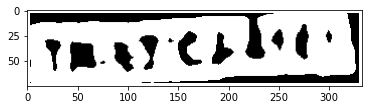

1CJ4


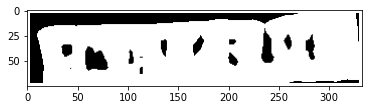

1


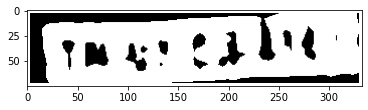

J1


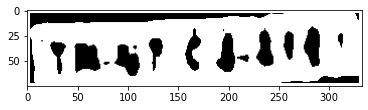

TYC414


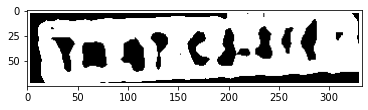

T4TCF14


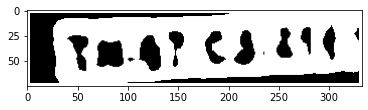

I4TC44


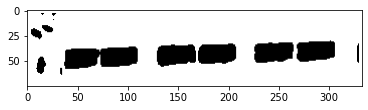

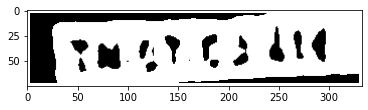

A4


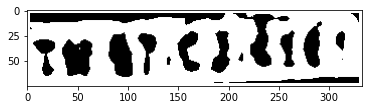

TV4TCJI4


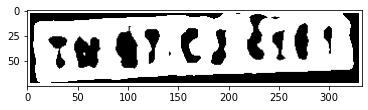

T47CJI4


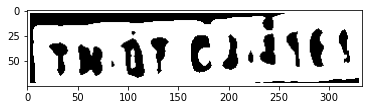

T4JCJ141


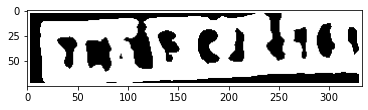

TWCJA4


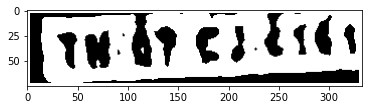

1W7IJI4


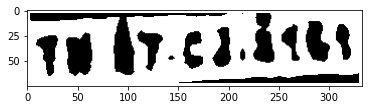

TVTCJA141


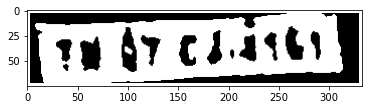

V4J4


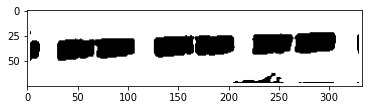

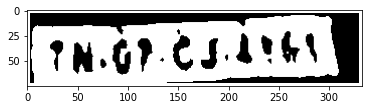

V7Z


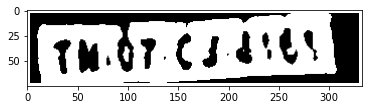

TWC41


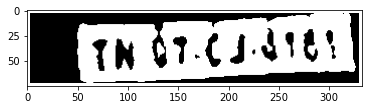

C46


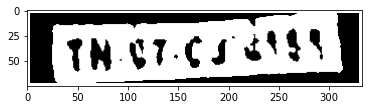

TW4


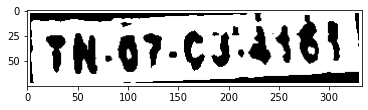

TW97CJA441


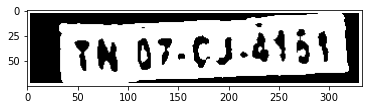

WCS


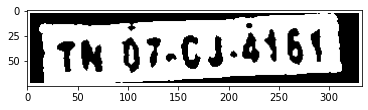

WQC464


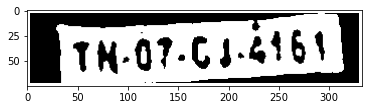

HQC6


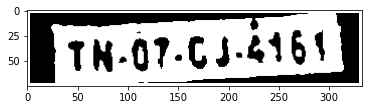

HQC6


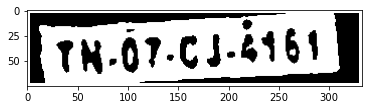

THQCJ6


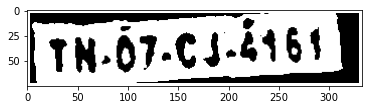

THQ7C4164


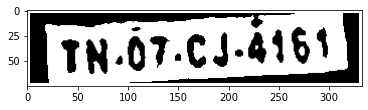

TWQCJ46


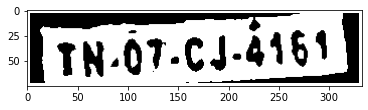

TWQCJ46


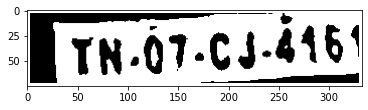

TNQTCJ446


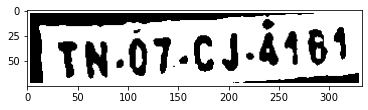

TNQ7CJ4464


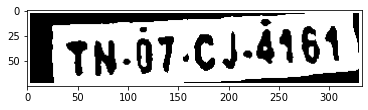

TN07CJ4161


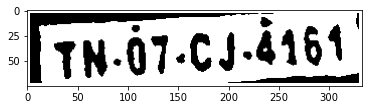

TW07CJ4464


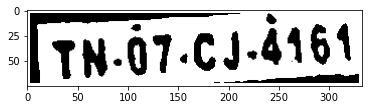

TWQ7CJ4461


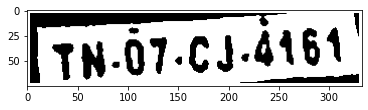

TW07CJ4161


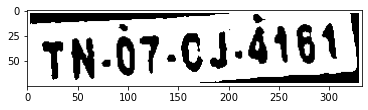

TWQTCJ4461


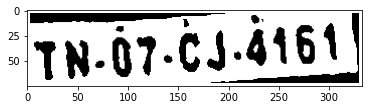

TW07C44461


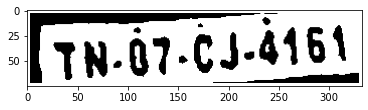

TW07CJ4461


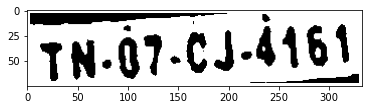

TW07CJ4461


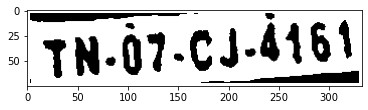

TW07CJ4461


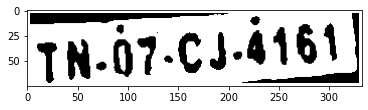

TN07CJ4461


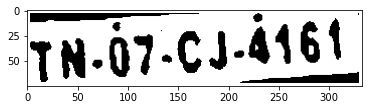

TN07CJ4461


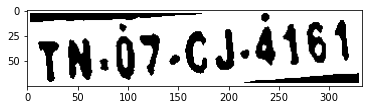

THQ7CJ4161


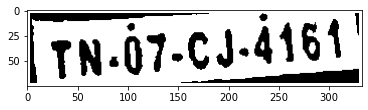

TN07CJ4461


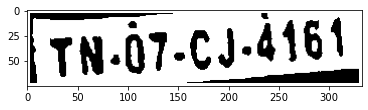

TW07CJ4161


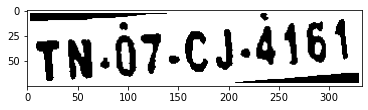

TNQ7CJ4461


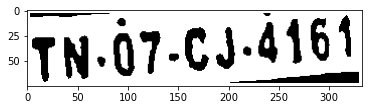

TN07C44164


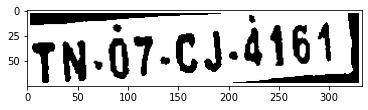

TNG7CJ4164


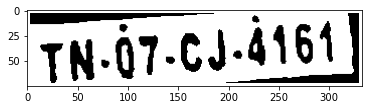

TNQTCJ4164


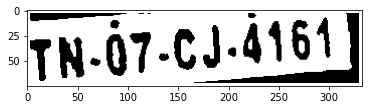

TNQTCJ4164


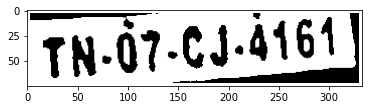

TNQTCJ4464


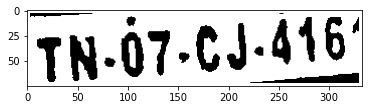

TN0TCJ446


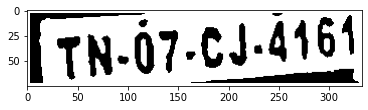

TN07CJ4464


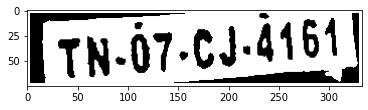

TN0TCJ4464


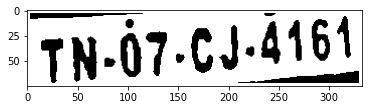

TN07CJ4464


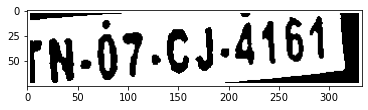

CN07CJ4161


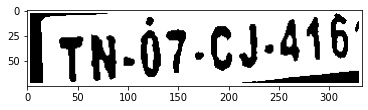

TN07CJ446


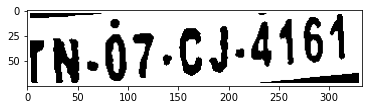

TN07CJ4164


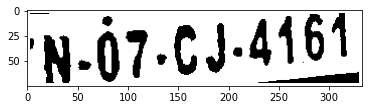

N07CJ4464


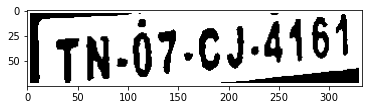

TN07CJ4464


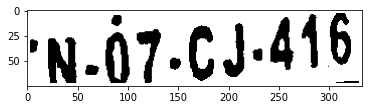

N07CJ446


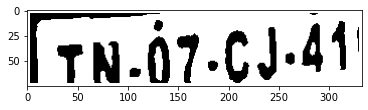

TN07CJ41


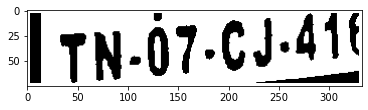

1TN07CJ41


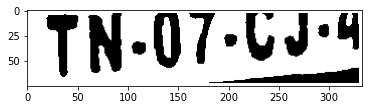

TN07LJA


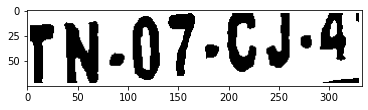

TN07CJ4


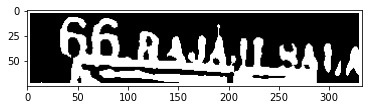

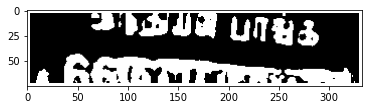

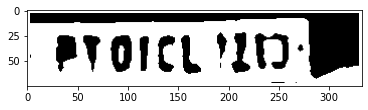

FTVCL1D


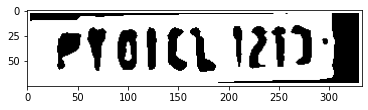

PTGC12J1


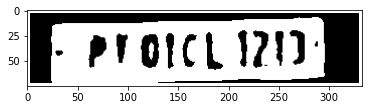

P0CL21


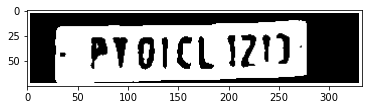

0CLZ


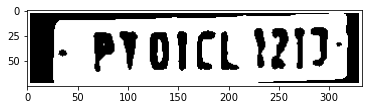

PJ0CL12J


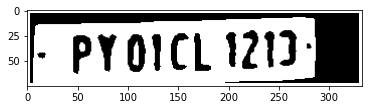

PT0CLZJ


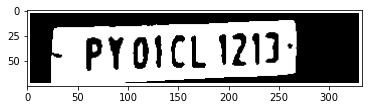

PTCLZ


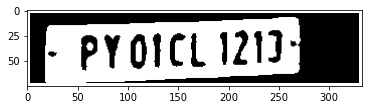

PT0CLZJ


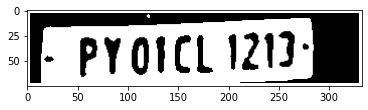

PT0CLZJ


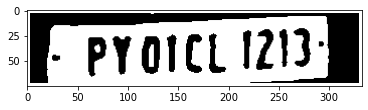

PT0CLZJ


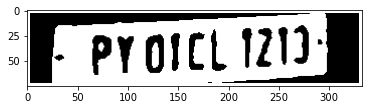

PT0CLZJ


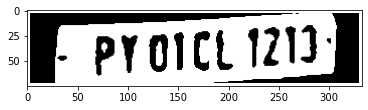

PT0CLZJ


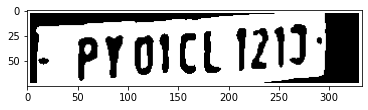

PT0CLZJ


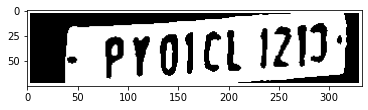

PY0CLZJ


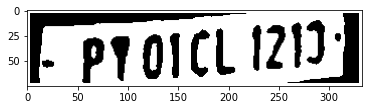

PT0CLZJ


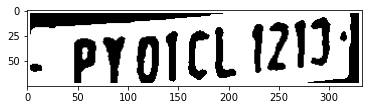

PT0ICLJZJJ


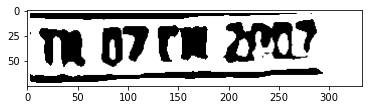

077


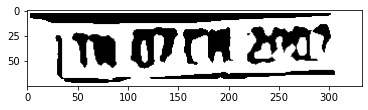

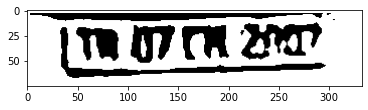

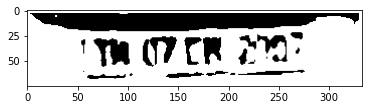

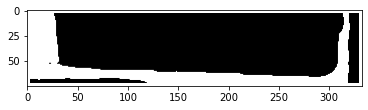

I


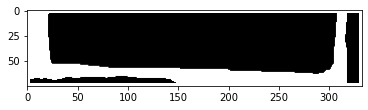

I


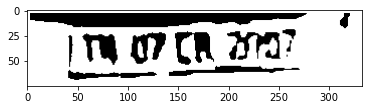

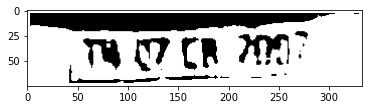

CC


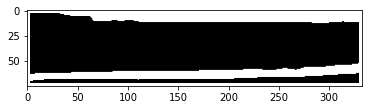

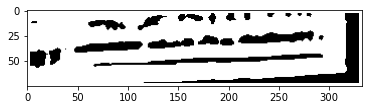

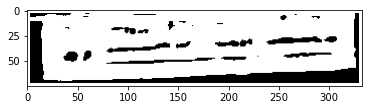

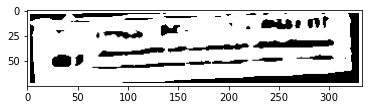

In [13]:
cam = cv2.VideoCapture(r'C:\Users\Admin\Desktop\Fall21-22\DIP\J component\trim.mp4')
if cam.isOpened() == False:
    print("Video not imported")

plate_list = []  
info_list = []
while(cam.isOpened()):
    ret, frame = cam.read()
    if ret == True:
        car_plate, plate_img = plate_detect(frame)
        cv2.imshow("License Video",car_plate)
        if len(plate_img) > 0:
            plate_char = segment_characters(plate_img)
            number_plate = show_results(plate_char)
            print(number_plate)
          
                
        if cv2.waitKey(1) == 27:
            break
    else:
        break

cam.release()
cv2.destroyAllWindows()

In [ ]:
#Print plates where length== 10 or average plates idea